# Imports

In [303]:
import os
from functools import partial
import json

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)

from gerrychain.metrics import efficiency_gap, mean_median, partisan_gini
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

# Downloading state data

In [304]:
graph_path = "./texas.json"
graph = Graph.from_json(graph_path)
with open (graph_path, "r") as myfile:
    data=myfile.readlines()
graph_dict = json.loads(data[0])

# Chain stuff

In [305]:
pop_count = 0

for i in graph.nodes:
    pop_count += graph.nodes[i]["TOTPOP"]
    
print(pop_count)

25145561.0


In [306]:
graph.nodes[0]

{'boundary_node': False,
 'area': 5616315.599709552,
 'CNTYVTD': '10001',
 'VTD': '0001',
 'WHITE': 2053.0,
 'OTHER': 89.0,
 'HISPANIC': 401.0,
 'TOTPOP': 3131.0,
 'VAP': 2341.0,
 'BLACK': 606.0,
 'BLKHISP': 989.0,
 'WVAP': 1677.0,
 'HISPVAP': 217.0,
 'BHVAP': 592.0,
 'BVAP': 378.0,
 'OTHVAP': 72.0,
 'COUNTY': 'Anderson',
 'FIPS': 1,
 'PRES12R': 754,
 'PRES12D': 261,
 'SEN12R': 713,
 'SEN12D': 285,
 'TOTVR12': 1629,
 'TOTTO12': 1026,
 'SEN14R': 441,
 'SEN14D': 110,
 'GOV14R': 424,
 'GOV14D': 130,
 'TOTVR14': 1712,
 'TOTTO14': 576,
 'PRES16D': 262,
 'PRES16R': 742,
 'TOTVR16': 1799,
 'TOTTO16': 1030,
 'USCD': '05',
 'SEND': 3,
 'HD': 8,
 'AREA': 6,
 'PERIM': 15}

In [307]:
%%time
num_dist = 36

# Exercise: Compute exact population from your data.
pop = pop_count

my_updaters = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "cut_edges": cut_edges,
    "SEN12": Election("SEN12", {"democratic":"SEN12D","republican":"SEN12R"}),
    "PRES12": Election("PRES12", {"democratic":"PRES12D","republican":"PRES12R"}),
    "SEN14": Election("SEN14", {"democratic":"SEN14D","republican":"SEN14R"}),
    "GOV14": Election("GOV14", {"democratic":"GOV14D","republican":"GOV14R"}),
    "PRES16": Election("PRES16", {"democratic":"PRES16D","republican":"PRES16R"})
}


new_plan = recursive_tree_part(graph,
                               range(num_dist),
                               pop/num_dist,
                               "TOTPOP",
                               0.002,
                               3)
initial_partition = Partition(graph,
                              new_plan,
                              my_updaters)

CPU times: user 53 s, sys: 1.41 s, total: 54.4 s
Wall time: 54.6 s


In [308]:
%%time
proposal = partial(recom,
                   pop_col = "TOTPOP",
                   pop_target = pop/num_dist,
                   epsilon = 0.01,
                   node_repeats = 3)

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 2 * len(initial_partition["cut_edges"])
)

CPU times: user 146 ms, sys: 3.33 ms, total: 149 ms
Wall time: 160 ms


In [309]:
%%time
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(initial_partition, 0.01),
        compactness_bound,
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=50000,
)

CPU times: user 33.5 ms, sys: 1.65 ms, total: 35.1 ms
Wall time: 36.6 ms


# Pulling data from chain run

In [310]:
%%time

data = []

for step in tqdm_notebook(chain):
    data.append([step["SEN12"].wins("republican"),
                         mean_median(step["SEN12"]),
                         partisan_gini(step["SEN12"]),
                         step["SEN12"].percents("republican")])


CPU times: user 7h 25min 21s, sys: 3min 14s, total: 7h 28min 36s
Wall time: 23h 27min 44s


# Visualization

In [301]:
print(data[5674])

0.4009086392558496


In [287]:
for plan in tqdm_notebook(data):
    print(plan)

0.3353380767478687
0.3353380767478687
0.3353380767478687
0.3353380767478687
0.3353380767478687
0.3353380767478687
0.3353380767478687
0.3353380767478687
0.3353380767478687
0.34399978755609845
0.34399978755609845
0.34399978755609845
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32298903147302743
0.32218911005499706
0.32218911005499706
0.32218911005499706
0.32218911005499706
0.32218911005499706
0.3221891

0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.34453715241084526
0.3384590190780316
0.3384590190780316
0.3384590190780316
0.3384590190780316
0.33650302289188566
0.33650302289188566
0.33650302289188566
0.33650302289188566
0.33

0.3472989525785566
0.3472989525785566
0.35230648553022464
0.35230648553022464
0.35230648553022464
0.35230648553022464
0.35230648553022464
0.35230648553022464
0.35230648553022464
0.35230648553022464
0.35230648553022464
0.35230648553022464
0.35230648553022464
0.35230648553022464
0.35230648553022464
0.35230648553022464
0.35230648553022464
0.35230648553022464
0.35230648553022464
0.35230648553022464
0.3536219258073251
0.3536219258073251
0.3536219258073251
0.3536219258073251
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.3560247513017321
0.35602475130

0.39002545917439535
0.38960571921057036
0.38960571921057036
0.3961645620002171
0.3961645620002171
0.3961645620002171
0.40422789539227894
0.40422789539227894
0.40422789539227894
0.40496853509594777
0.40496853509594777
0.40496853509594777
0.40496853509594777
0.40496853509594777
0.40496853509594777
0.40496853509594777
0.40496853509594777
0.40496853509594777
0.40496853509594777
0.40496853509594777
0.40496853509594777
0.40496853509594777
0.40496853509594777
0.40496853509594777
0.40496853509594777
0.40496853509594777
0.40496853509594777
0.40496853509594777
0.40496853509594777
0.40800707319094853
0.40800707319094853
0.40800707319094853
0.40800707319094853
0.41402426125712116
0.41402426125712116
0.41402426125712116
0.40496853509594777
0.40496853509594777
0.40496853509594777
0.40496853509594777
0.40496853509594777
0.4021763465186704
0.384709705106983
0.384709705106983
0.384709705106983
0.384709705106983
0.4021763465186704
0.4021763465186704
0.4021763465186704
0.38343532782115475
0.3834353278211

0.42699230361058804
0.4177332773604623
0.4177332773604623
0.4177332773604623
0.41058698988015463
0.41058698988015463
0.41058698988015463
0.41058698988015463
0.41058698988015463
0.41058698988015463
0.41058698988015463
0.41058698988015463
0.41058698988015463
0.414343750709244
0.414343750709244
0.414343750709244
0.414343750709244
0.414343750709244
0.414343750709244
0.414343750709244
0.414343750709244
0.414343750709244
0.414343750709244
0.414343750709244
0.414343750709244
0.414343750709244
0.414343750709244
0.414343750709244
0.414343750709244
0.414343750709244
0.414343750709244
0.3834675920188375
0.3920269044303322
0.3920269044303322
0.3920269044303322
0.3920269044303322
0.3920269044303322
0.39034997131382676
0.39034997131382676
0.39034997131382676
0.39034997131382676
0.39034997131382676
0.39034997131382676
0.39034997131382676
0.39034997131382676
0.39034997131382676
0.39034997131382676
0.39034997131382676
0.39034997131382676
0.39034997131382676
0.39034997131382676
0.39034997131382676
0.390

0.4359776466871417
0.4359776466871417
0.4359776466871417
0.4359776466871417
0.4359776466871417
0.4359776466871417
0.4359776466871417
0.4359776466871417
0.4359776466871417
0.45634436415778673
0.45634436415778673
0.45634436415778673
0.45634436415778673
0.45634436415778673
0.45634436415778673
0.45634436415778673
0.43572111873437774
0.43303221057303537
0.43303221057303537
0.43572111873437774
0.456667836774978
0.456667836774978
0.456667836774978
0.456667836774978
0.456667836774978
0.43572111873437774
0.43572111873437774
0.43572111873437774
0.42987579301985107
0.4498317742080409
0.4498317742080409
0.4498317742080409
0.4498317742080409
0.4498317742080409
0.4498317742080409
0.4498317742080409
0.4498317742080409
0.4498317742080409
0.4498317742080409
0.4498317742080409
0.4498317742080409
0.4498317742080409
0.455852442116408
0.455852442116408
0.455852442116408
0.455852442116408
0.4498317742080409
0.4498317742080409
0.4498317742080409
0.4498317742080409
0.4498317742080409
0.437254856542821
0.43725

0.4758382862252788
0.4758382862252788
0.4758382862252788
0.4758382862252788
0.4815070432505132
0.47767644253695757
0.47767644253695757
0.47767644253695757
0.47767644253695757
0.4758382862252788
0.4758382862252788
0.4758382862252788
0.4758382862252788
0.4758382862252788
0.4758382862252788
0.4758382862252788
0.4758382862252788
0.4758382862252788
0.4758382862252788
0.4758382862252788
0.4758382862252788
0.4758382862252788
0.4758382862252788
0.4758382862252788
0.44960650983373457
0.456667836774978
0.456667836774978
0.456667836774978
0.456667836774978
0.456667836774978
0.4758382862252788
0.4758382862252788
0.4758382862252788
0.4758382862252788
0.4758382862252788
0.4758382862252788
0.46561196185851383
0.4758382862252788
0.46561196185851383
0.46561196185851383
0.46561196185851383
0.46561196185851383
0.46561196185851383
0.46561196185851383
0.46561196185851383
0.46561196185851383
0.46561196185851383
0.46561196185851383
0.46561196185851383
0.46561196185851383
0.46561196185851383
0.465611961858513

0.5211793496841992
0.5211793496841992
0.5211793496841992
0.5211793496841992
0.5211793496841992
0.5211793496841992
0.5211793496841992
0.5211793496841992
0.49940568382379424
0.49940568382379424
0.49940568382379424
0.49940568382379424
0.49940568382379424
0.4938373751783167
0.4938373751783167
0.4938373751783167
0.4938373751783167
0.4938373751783167
0.4938373751783167
0.4938373751783167
0.4938373751783167
0.4956421985596169
0.4956421985596169
0.4976574137848184
0.49967387103008437
0.49967387103008437
0.49967387103008437
0.49967387103008437
0.49967387103008437
0.49967387103008437
0.49967387103008437
0.49967387103008437
0.48847489356562696
0.48847489356562696
0.48847489356562696
0.48847489356562696
0.49967387103008437
0.49967387103008437
0.49967387103008437
0.49967387103008437
0.49967387103008437
0.49967387103008437
0.49967387103008437
0.49967387103008437
0.49967387103008437
0.49967387103008437
0.49967387103008437
0.5091283863368669
0.5091283863368669
0.5033900116640566
0.49967387103008437
0.

0.5526615311771562
0.5526615311771562
0.5526615311771562
0.5526615311771562
0.5526615311771562
0.5526615311771562
0.5526615311771562
0.5526615311771562
0.5526615311771562
0.5526615311771562
0.5526615311771562
0.5526615311771562
0.5526615311771562
0.5526615311771562
0.5526615311771562
0.5526615311771562
0.5566831766005154
0.5566831766005154
0.5566831766005154
0.5640215333422578
0.5640215333422578
0.5640215333422578
0.5640215333422578
0.5640215333422578
0.5844153361351232
0.5861987877171246
0.5861987877171246
0.5861987877171246
0.5861987877171246
0.5861987877171246
0.5861987877171246
0.5861987877171246
0.5861987877171246
0.5861987877171246
0.5837902764402148
0.5837902764402148
0.5837902764402148
0.5837902764402148
0.5837902764402148
0.5837902764402148
0.5837902764402148
0.5837902764402148
0.5837902764402148
0.5837902764402148
0.5546753650201927
0.5486059804083733
0.5486059804083733
0.5486059804083733
0.5435303784838074
0.5435303784838074
0.5435303784838074
0.5435303784838074
0.5435303784

0.5714964003782981
0.5714964003782981
0.5714964003782981
0.5842431667280276
0.5842431667280276
0.5842431667280276
0.5842431667280276
0.5844153361351232
0.5844153361351232
0.5844153361351232
0.5844153361351232
0.5844153361351232
0.5844153361351232
0.5844153361351232
0.5844153361351232
0.5844153361351232
0.5844153361351232
0.5844153361351232
0.5844153361351232
0.5844153361351232
0.5844153361351232
0.5844153361351232
0.5844153361351232
0.5867870738807641
0.5867870738807641
0.5867870738807641
0.5881672229395571
0.5881672229395571
0.5881672229395571
0.5881672229395571
0.5881672229395571
0.5881672229395571
0.5881672229395571
0.5881672229395571
0.5881672229395571
0.5881672229395571
0.5881672229395571
0.5881672229395571
0.5881672229395571
0.5881672229395571
0.5881672229395571
0.5881672229395571
0.5881672229395571
0.5881672229395571
0.5881672229395571
0.5881672229395571
0.5867870738807641
0.5867870738807641
0.5867870738807641
0.5867870738807641
0.5867870738807641
0.5867870738807641
0.5867870738

0.6121652262183725
0.6121652262183725
0.6121652262183725
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6175238976498357
0.6217931012072075
0.6217931012072075
0.6217931012072075
0.6217931012072075
0.6217931012072075
0.6217931012072075
0.6217931012072075
0.6217931012072075
0.6217931012072075
0.6217931012072075
0.6220069492381676
0.6220069492381676
0.6239300363162165
0.6239300363162165
0.6239300363162165
0.6239300363162165
0.6217931012072075
0.6217931012072075
0.6217931012072075
0.6217931012

0.6563101083931118
0.6563101083931118
0.6563101083931118
0.6563101083931118
0.6563101083931118
0.6563101083931118
0.6563101083931118
0.6563101083931118
0.6550869503811055
0.6550869503811055
0.6550869503811055
0.6550869503811055
0.6550869503811055
0.6550869503811055
0.6550869503811055
0.6550869503811055
0.6550869503811055
0.6550869503811055
0.6550869503811055
0.6547699010619951
0.6547699010619951
0.6547699010619951
0.6547699010619951
0.6547699010619951
0.6547699010619951
0.6547699010619951
0.6547699010619951
0.6371688496274927
0.6371688496274927
0.6547699010619951
0.6547699010619951
0.6547699010619951
0.6547699010619951
0.6547699010619951
0.6547699010619951
0.6547699010619951
0.6537659540340506
0.6537659540340506
0.6537659540340506
0.6537659540340506
0.6537659540340506
0.6537659540340506
0.6537659540340506
0.6537659540340506
0.6537659540340506
0.6537659540340506
0.6537659540340506
0.6537659540340506
0.6537659540340506
0.6537659540340506
0.6537659540340506
0.6537659540340506
0.6537659540

0.6789011252504839
0.6789011252504839
0.6789011252504839
0.6789011252504839
0.6789011252504839
0.6789011252504839
0.6789011252504839
0.6789011252504839
0.6789011252504839
0.6789011252504839
0.6789011252504839
0.6788380971687277
0.6788380971687277
0.6788380971687277
0.6833601058301049
0.6833601058301049
0.6833601058301049
0.6833601058301049
0.6833601058301049
0.6833601058301049
0.6833601058301049
0.6833601058301049
0.6833601058301049
0.6833601058301049
0.6833601058301049
0.6833601058301049
0.6833601058301049
0.6833601058301049
0.6833601058301049
0.6803386915072741
0.6803386915072741
0.6803386915072741
0.6771095806036173
0.6771095806036173
0.6771095806036173
0.6771095806036173
0.6771095806036173
0.6771095806036173
0.6771095806036173
0.6771095806036173
0.6771095806036173
0.6771095806036173
0.6771095806036173
0.6771095806036173
0.6771095806036173
0.6771095806036173
0.6771095806036173
0.6771095806036173
0.6771095806036173
0.6771095806036173
0.6771095806036173
0.6771095806036173
0.6784508320

0.6894547145680735
0.6894547145680735
0.6894547145680735
0.6894547145680735
0.6894547145680735
0.6894547145680735
0.6894547145680735
0.684486914956521
0.6890407501238677
0.6890407501238677
0.6890407501238677
0.6890407501238677
0.6890407501238677
0.6894547145680735
0.6894547145680735
0.6894547145680735
0.6894547145680735
0.6894547145680735
0.6894547145680735
0.6894547145680735
0.6894547145680735
0.6894547145680735
0.6894547145680735
0.6894547145680735
0.6894547145680735
0.6894547145680735
0.6894547145680735
0.6894547145680735
0.6894547145680735
0.6894547145680735
0.6894547145680735
0.6830122834471203
0.6830122834471203
0.6849363367693783
0.6849363367693783
0.6849363367693783
0.6849363367693783
0.6849363367693783
0.6849363367693783
0.6830122834471203
0.6830122834471203
0.6830122834471203
0.6799078203491553
0.6799078203491553
0.6799078203491553
0.6799078203491553
0.6799078203491553
0.6799078203491553
0.6799078203491553
0.6799078203491553
0.6799078203491553
0.6799078203491553
0.67990782034

0.7092076464113009
0.7092076464113009
0.7092076464113009
0.7092076464113009
0.7092076464113009
0.7092076464113009
0.7092076464113009
0.7092076464113009
0.7092076464113009
0.7092076464113009
0.7092076464113009
0.7007007007007007
0.7007007007007007
0.7007007007007007
0.7007007007007007
0.7007007007007007
0.7007007007007007
0.7007007007007007
0.7007007007007007
0.7007007007007007
0.7007007007007007
0.7007007007007007
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551683886
0.7006874551

0.7082422339866128
0.7082422339866128
0.7082422339866128
0.7082422339866128
0.7082422339866128
0.7082422339866128
0.7082422339866128
0.7082422339866128
0.7248226510950714
0.7248226510950714
0.7246424584443096
0.7246424584443096
0.7246424584443096
0.7246424584443096
0.7246424584443096
0.7238719074576687
0.7238719074576687
0.7238719074576687
0.7238719074576687
0.7238719074576687
0.7248027854375371
0.7248027854375371
0.7422742923966477
0.7422742923966477
0.7422742923966477
0.7422742923966477
0.7422742923966477
0.7422742923966477
0.7422742923966477
0.7422742923966477
0.7422742923966477
0.7422742923966477
0.7422742923966477
0.745039515077112
0.745039515077112
0.745039515077112
0.745039515077112
0.745039515077112
0.745039515077112
0.745039515077112
0.745039515077112
0.745039515077112
0.7448457489737838
0.7448457489737838
0.7448457489737838
0.7448457489737838
0.7448457489737838
0.7448457489737838
0.7448457489737838
0.7448457489737838
0.7448457489737838
0.7586869462370054
0.7586869462370054
0.

0.7789228587865966
0.7789228587865966
0.7789228587865966
0.7789228587865966
0.7789228587865966
0.7789228587865966
0.7789228587865966
0.7789228587865966
0.7789228587865966
0.7789228587865966
0.7789228587865966
0.7789228587865966
0.7789228587865966
0.7789228587865966
0.7789228587865966
0.7789228587865966
0.7789228587865966
0.7789228587865966
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206788101
0.7956362206


CPU times: user 530 ms, sys: 42 ms, total: 572 ms
Wall time: 646 ms


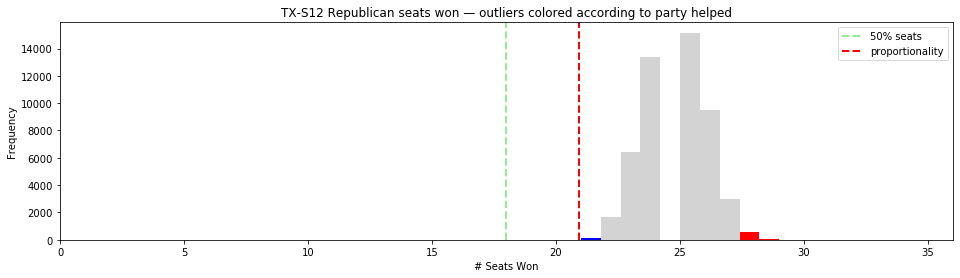

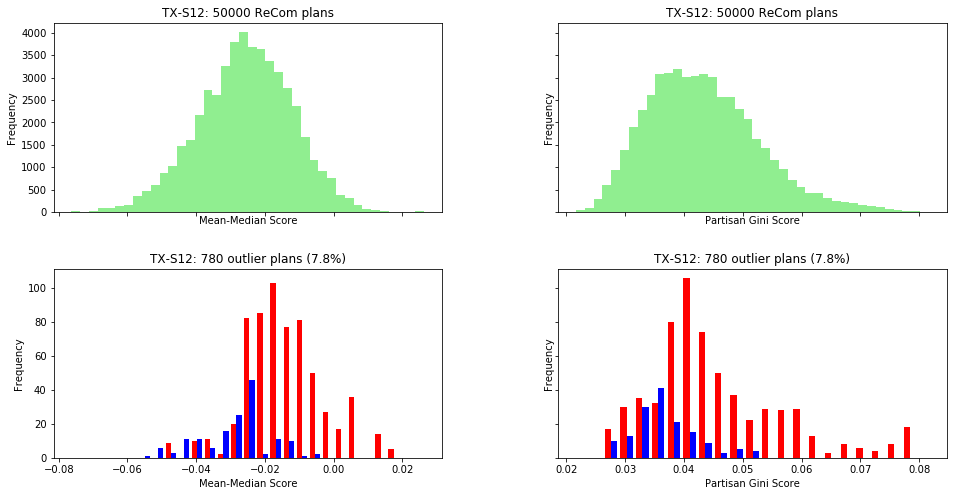

In [313]:
%%time
# fig, votes = plt.subplots(figsize=(16,4))
fig, seats = plt.subplots(figsize=(16,4))
fig, ax = plt.subplots(2,2, figsize=(16,8), sharex="col", sharey="row")

plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Variables
inliers = [22,27]
bins_num = 20
out_bins_num = 10
title = "TX-S12: 50000 ReCom plans"

# Colors
seats_colors = ["red", "blue", "lightgray"]
party_colors = ["red", "blue"]
neutral = "lightgreen"

# Creating Datasets
mm = []
pg = []
vs = []
mm_routliers = []
mm_doutliers = []
pg_routliers = []
pg_doutliers = []
seats_routliers = []
seats_doutliers = []
seats_inliers = []
vs_routliers = []
vs_doutliers = []


for plan in tqdm_notebook(data):
    mm.append(plan[1])
    pg.append(plan[2])
    vs.append(plan[3])
    if plan[0] < inliers[0]:
        seats_doutliers.append(plan[0])
        mm_doutliers.append(plan[1])
        pg_doutliers.append(plan[2])
        vs_doutliers.append(plan[3])
    if plan[0] > inliers[1]:
        seats_routliers.append(plan[0])
        mm_routliers.append(plan[1])
        pg_routliers.append(plan[2])
        vs_routliers.append(plan[3])
    if plan[0] >= inliers[0] and plan[0] <= inliers[1]:
        seats_inliers.append(plan[0])

mms = [mm_routliers, mm_doutliers]
pgs = [pg_routliers, pg_doutliers]
seats_colored = [seats_routliers, seats_doutliers, seats_inliers]

# More variables
num_outliers = str(len(mm_doutliers) + len(mm_routliers))
pct_outliers = str(round((len(mm_doutliers) + len(mm_routliers)) / 10000 * 100, 1))
title_w = "TX-S12: " + num_outliers + " outlier plans " + "(" + pct_outliers + "%)"

# Plotting the votes shares boxplots
# votes.boxplot(vs, positions=range(len(data.columns)))

# votes.set_title("Votes Shares Boxplots")
# votes.set_ylabel("Republican Votes %")
# votes.set_xlabel("District #")


# Plotting the seats histogram
seats.hist(seats_colored, bins=out_bins_num, stacked=True, color=seats_colors)

seats.set_title("TX-S12 Republican seats won — outliers colored according to party helped")
seats.set_ylabel("Frequency")
seats.set_xlabel("# Seats Won")
seats.set_xlim(0, num_dist)
seats.axvline(x = num_dist/2, color=neutral, linestyle="dashed", linewidth=2, label="50% seats")
seats.axvline(x = num_dist * initial_partition["SEN12"].percent("republican"), color="red", linestyle="dashed", linewidth=2, label="proportionality")
seats.legend()
# seats.set_xticks(1)

# Plotting the whole dataset
ax[0,0].hist(mm, bins=2*bins_num, color=neutral)
ax[0,1].hist(pg, bins=2*bins_num, color=neutral)

ax[0,0].set_title(title)
ax[0,0].set_ylabel("Frequency")
ax[0,0].set_xlabel("Mean-Median Score")

ax[0,1].set_title(title)
ax[0,1].set_ylabel("Frequency")
ax[0,1].set_xlabel("Partisan Gini Score")

# Plotting the winnowed data
ax[1,0].hist(mms, bins=bins_num, color=party_colors)
ax[1,1].hist(pgs, bins=bins_num, color=party_colors)
# ax[1,1].set_ylim((0,40))

ax[1,0].set_title(title_w)
ax[1,0].set_ylabel("Frequency")
ax[1,0].set_xlabel("Mean-Median Score")

ax[1,1].set_title(title_w)
ax[1,1].set_ylabel("Frequency")
ax[1,1].set_xlabel("Partisan Gini Score")

In [272]:
sorted(list(vs[55]))

[0.32218911005499706,
 0.3472650727159008,
 0.35969865508083193,
 0.36941798454255403,
 0.3815099591902922,
 0.38412761431054115,
 0.39609924200192576,
 0.4056710123207915,
 0.4186104729928727,
 0.4659674179870565,
 0.475581058576497,
 0.4797250989948218,
 0.4849147669913181,
 0.5045032717747728,
 0.5117271235262594,
 0.540787554691298,
 0.5424515215966613,
 0.6010282137889926,
 0.6068644147979941,
 0.6086479585986531,
 0.6198444244988673,
 0.6475018298085442,
 0.648041484243645,
 0.6517950606753771,
 0.6626435814092022,
 0.6788380971687277,
 0.6833601058301049,
 0.6865083755615056,
 0.6905887462001364,
 0.7086471495153202,
 0.7285348619521368,
 0.7401110772257324,
 0.7404272223177794,
 0.7493276632937775,
 0.7566781863217692,
 0.8032976168483281]

In [273]:
data = []

for i in range(num_dist):
    for j in range(1000):
        data.append(sorted(list(vs[j]))[i])

In [274]:
vs[0]

(0.6828881139586144,
 0.6567352792960421,
 0.6296051348578502,
 0.5052986748415784,
 0.4020456026058632,
 0.7997332678851755,
 0.4778352752971473,
 0.675617707618394,
 0.7059090136536174,
 0.609500791376139,
 0.3529781601588352,
 0.71189392477395,
 0.6082661236198519,
 0.6613686129867534,
 0.7606046263976809,
 0.6626435814092022,
 0.3815099591902922,
 0.6935465836194294,
 0.614721964081174,
 0.5574893728572237,
 0.43987472309220077,
 0.5036346831205816,
 0.5000235826808792,
 0.7586869462370054,
 0.3827912229037044,
 0.4719731279738034,
 0.4293858765252326,
 0.3353380767478687,
 0.47610450066346177,
 0.47066157940186454,
 0.4933921351006459,
 0.4837385379753772,
 0.6955942900816054,
 0.4189425757430877,
 0.7514672209261711,
 0.6621832983369127)

In [275]:
votes.boxplot(vs, positions=range(len(data.columns)))

votes.set_title("Votes Shares Boxplots")
votes.set_ylabel("Republican Votes %")
votes.set_xlabel("District #")

AttributeError: 'list' object has no attribute 'columns'